# Import Library

In [1]:
# file directory manager
import os
import shutil
import pickle
from google.colab import files 

# data process
import numpy as np
import pandas as pd

# tensorflow utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# image processing
from PIL import Image
import cv2

# model evaluating
from sklearn.metrics import confusion_matrix, classification_report

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# mount drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Gathering Data

In [ ]:
shutil.rmtree('data', ignore_errors=True)

In [ ]:
! mkdir data

## Download Dataset from Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Initialize Kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Download vipoooool/new-plant-diseases-dataset Dataset

In [ ]:
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset
! mkdir data/kaggle
! unzip new-plant-diseases-dataset.zip -d data/kaggle
os.remove('new-plant-diseases-dataset.zip')

## Copy Dataset

In [ ]:
name_classes = ("gray_leaf_spot", "common_rust", "northern_leaf_blight", "healthy")
finaldata_dir = 'data/finaldata'

name_classes

('gray_leaf_spot', 'common_rust', 'northern_leaf_blight', 'healthy')

In [ ]:
shutil.rmtree(finaldata_dir, ignore_errors=True)

os.mkdir(finaldata_dir)
for name in name_classes:
  os.mkdir(os.path.join(finaldata_dir, name))

### Copy vipoooool/new-plant-diseases-dataset Dataset

In [ ]:
source_classes = []

list_classes = os.listdir("data/kaggle/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")

for name_class in list_classes:
  if "maize" in name_class:
    source_classes.append(name_class)

source_classes.sort()
source_classes

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy']

In [ ]:
def copy_data(split):
  base_source_dir = "data/kaggle/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/{}".format(split)
  target_dir = "data/finaldata"

  for index, value in enumerate(source_classes):
    dest_dir = os.path.join(target_dir, name_classes[index])
    source_dir = os.path.join(base_source_dir, source_classes[index])
    list_data = os.listdir(source_dir)

    for data in list_data:
      source = os.path.join(source_dir, data)
      dest = os.path.join(dest_dir, data)
      shutil.copy(source, dest)

In [ ]:
copy_data("train")
copy_data("valid")

# EDA

In [ ]:
name_classes = ("gray_leaf_spot", "common_rust", "northern_leaf_blight", "healthy")
finaldata_dir = 'data/finaldata'

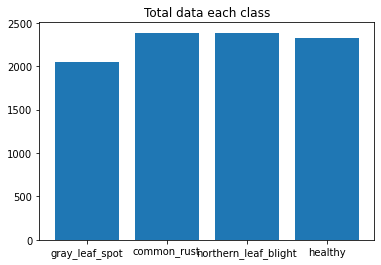

In [ ]:
dict_classes = {}

for name_class in name_classes:
  list_file = os.listdir(os.path.join(finaldata_dir, name_class))
  dict_classes[name_class] = len(list_file)

plt.figure(figsize=(6,4))
plt.bar(x=dict_classes.keys(), height=dict_classes.values())
plt.title("Total data each class")
plt.show()


healthy


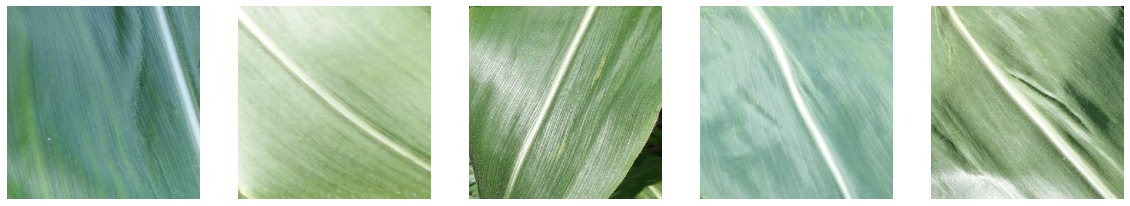


northern_leaf_blight


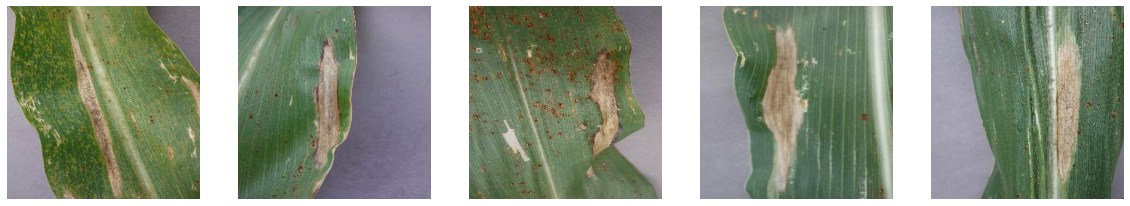


common_rust


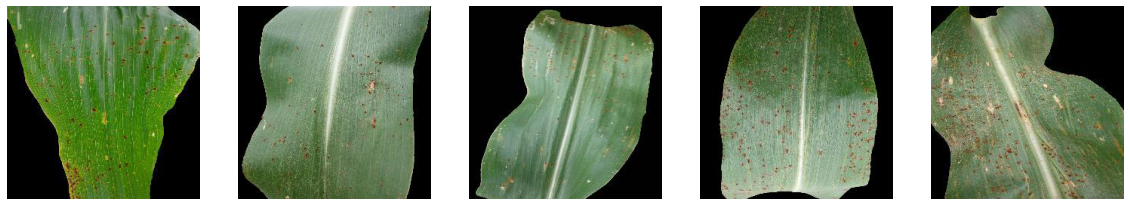


gray_leaf_spot


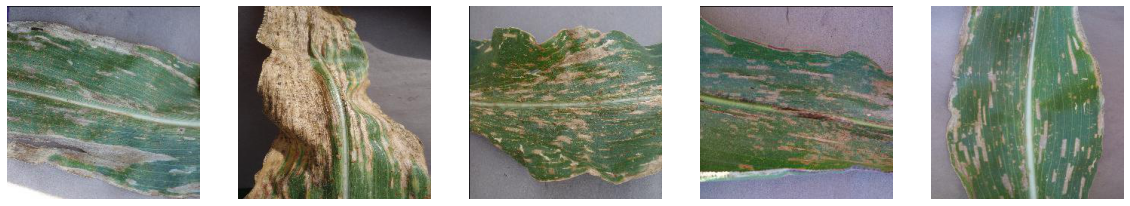

In [ ]:
list_data_class = os.listdir(finaldata_dir)
for item in list_data_class:
  print("")
  print(item)
  class_dir = os.path.join(finaldata_dir, item)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
  plt.show()

In [ ]:
for name_class in name_classes:
  dir = os.path.join(finaldata_dir, name_class)
  print(name_class)
  
  max_h, min_h, max_w, min_w = 0, 99999, 0, 99999
  avg_h, avg_w = 0, 0

  list_imgs = os.listdir(dir)
  len_list = len(list_imgs)

  for img_name in list_imgs:
    img_path = os.path.join(dir, img_name)
    img = Image.open(img_path)
    
    w, h = img.size

    avg_w = avg_w + w
    avg_h = avg_h + h

    if w > max_w: max_w = w
    if w < min_w: min_w = w
    if h > max_h: max_h = h
    if h < min_h: min_h = h
  
  avg_w = avg_w // len_list
  avg_h = avg_h // len_list
  
  print("min width: {} , max width: {} , avg_width: {}".format(min_w, max_w, avg_w))
  print("min height: {} , max height: {} , avg height: {}".format(min_h, max_h, avg_h))
  print("")

gray_leaf_spot
min width: 256 , max width: 256 , avg_width: 256
min height: 256 , max height: 256 , avg height: 256

common_rust
min width: 256 , max width: 256 , avg_width: 256
min height: 256 , max height: 256 , avg height: 256

northern_leaf_blight
min width: 256 , max width: 256 , avg_width: 256
min height: 256 , max height: 256 , avg height: 256

healthy
min width: 256 , max width: 256 , avg_width: 256
min height: 256 , max height: 256 , avg height: 256



## Save Data

In [ ]:
shutil.rmtree('corn_finaldata.zip', ignore_errors=True)
!zip -r corn_finaldata.zip data/finaldata

In [ ]:
shutil.copy("corn_finaldata.zip", "drive/Shareddrives/Tanamin Team/Machine Learning/datasets/corn/corn_finaldata.zip")

# Load Data

prepare model save directory

In [3]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

load final data from drive

In [4]:
finaldata_dir = 'data/finaldata'

In [ ]:
shutil.rmtree(finaldata_dir, ignore_errors=True)
# extract zip file
! unzip "drive/Shareddrives/Tanamin Team/Machine Learning/datasets/corn/corn_finaldata.zip" -d .

choosing the label
- gray_leaf_spot : valid (bercak daun cercospora/bercak coklat sempit)
- common_rust : valid (karat daun)
- northern_leaf_blight : valid (hawar daun)
- Healthy : valid (sehat)

In [6]:
name_classes = ("gray_leaf_spot", "common_rust", "northern_leaf_blight", "healthy")
# delete label
delete_label = []

if len(delete_label) > 0:
  for label in delete_label:
    shutil.rmtree(os.path.join(finaldata_dir, label), ignore_errors=True)

# Modelling

## Preparing ImageDataGenerator

In [7]:
finaldata_dir = "data/finaldata"
img_dim = 224
img_shape = (224, 224, 3)

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.15 
)

train_generator = datagen.flow_from_directory(
    finaldata_dir,
    target_size =(img_dim, img_dim),
    batch_size = 100,
    class_mode = 'categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    finaldata_dir,
    target_size = (img_dim,img_dim),
    batch_size = 100,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 7776 images belonging to 4 classes.
Found 1369 images belonging to 4 classes.


In [9]:
train_generator.class_indices

{'common_rust': 0,
 'gray_leaf_spot': 1,
 'healthy': 2,
 'northern_leaf_blight': 3}

In [10]:
labels = []
for label in train_generator.class_indices:
  labels.append(label)

name_classes = labels
num_labels = len(labels)

print("Labels: {}".format(name_classes))
print("Num labels: {}".format(num_labels))

Labels: ['common_rust', 'gray_leaf_spot', 'healthy', 'northern_leaf_blight']
Num labels: 4


## Init Method

In [11]:
# define my callbacks include (EarlyStopping, ModelCheckpoint)
def my_callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

  return [mc]

In [12]:
# define method for showing plot learning curves
def plot_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(6, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [13]:
# define confusion matrix method
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(name_classes, rotation=45)
  ax.yaxis.set_ticklabels(name_classes, rotation=45)

  plt.show()

In [14]:
# define classification report method
def class_report(y_test, y_pred):
  print("Labels: ", name_classes)
  print()
  print(classification_report(y_test, y_pred))

In [15]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# save model history method
def saved_model_history(modelname, history):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [16]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "leaf_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "leaf_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(name_classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [17]:
# save all model with simplify function
def save_all_model(modelname, model, history):
  # save model
  saved_model(modelname, model)

  # save history as dict
  saved_model_history(modelname, history)

  # save best model
  best_model = tf.keras.models.load_model('best_{}.h5'.format(modelname))
  best_modelname = "BestMC_{}".format(modelname)
  saved_model(best_modelname, best_model)
  # clear best model h5 format
  os.remove('best_{}.h5'.format(modelname))

  # save tflite best model
  tflite_model_convert(best_modelname, modelname)

  %cp -av "saved_model_history" "drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models"
  %cp -av "saved_model" "drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models"
  %cp -av "tflite_model" "drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models"

## Model 1

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=img_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')  
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
# fitting model
history1 = model1.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_OwnModel.h5"),
)

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.7510
Epoch 1: val_accuracy improved from -inf to 0.87290, saving model to best_OwnModel.h5
78/78 [==============================] - 506s 6s/step - loss: 0.5420 - accuracy: 0.7510 - val_loss: 0.2602 - val_accuracy: 0.8729
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.8992
Epoch 2: val_accuracy improved from 0.87290 to 0.92622, saving model to best_OwnModel.h5
78/78 [==============================] - 493s 6s/step - loss: 0.2441 - accuracy: 0.8992 - val_loss: 0.1758 - val_accuracy: 0.9262
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9417
Epoch 3: val_accuracy improved from 0.92622 to 0.95325, saving model to best_OwnModel.h5
78/78 [==============================] - 486s 6s/step - loss: 0.1450 - accuracy: 0.9417 - val_loss: 0.1342 - val_accuracy: 0.9533
Epoch 4/50
78/78 [==============================] - ETA: 0s - lo

In [ ]:
score_train = model1.evaluate(train_generator)
score_valid = model1.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

14/14 [==============================] - 2s 168ms/step - loss: 0.1228 - accuracy: 0.9701
Accuracy (train):  0.9994856119155884
Accuracy (test): 0.970051109790802
Loss (train):  0.002592161763459444
Loss (test): 0.12277068942785263


### Plot Learning Curves

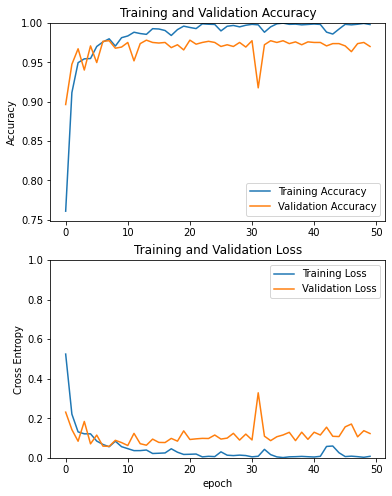

In [ ]:
plot_learning_curves(history1)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


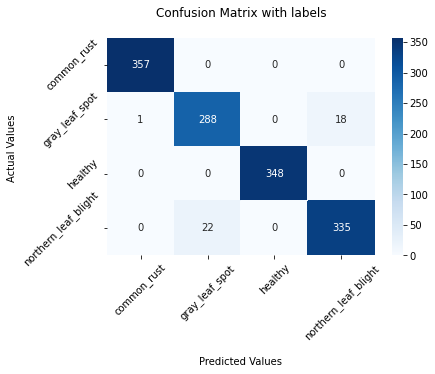

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  ['common_rust', 'gray_leaf_spot', 'healthy', 'northern_leaf_blight']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       0.93      0.94      0.93       307
           2       1.00      1.00      1.00       348
           3       0.95      0.94      0.94       357

    accuracy                           0.97      1369
   macro avg       0.97      0.97      0.97      1369
weighted avg       0.97      0.97      0.97      1369



### Save Model

In [ ]:
# save all model
modelname = "OwnModel"
save_all_model(modelname, model1, history1)

Export path:  saved_model/OwnModel
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  saved_model/BestMC_OwnModel
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  tflite_model/OwnModel
['leaf_ownmodel.tflite', 'leaf_ownmodel.txt']
'saved_model_history' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history'
'saved_model_history/OwnModel' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/OwnModel'
'saved_model' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model'
'saved_model/OwnModel' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/OwnModel'
'saved_model/OwnModel/variables' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/OwnModel/variables'
'saved_model/OwnModel/variables/variables.data-00000-of-00001' -> 'drive/Shareddrives/Tanamin Team/Machine Learnin

## Model 2

In [ ]:
from tensorflow.keras.applications import ResNet50    # underfit
from tensorflow.keras.applications import ResNet152V2 # overfit

model2 = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=img_shape)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')  
])

model2.layers[0].trainable = False

model2.summary()

234561536/234545216 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)             

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_ResNet152V2.h5")
)

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8499
Epoch 1: val_accuracy improved from -inf to 0.93718, saving model to best_ResNet152V2.h5
78/78 [==============================] - 46s 478ms/step - loss: 0.4099 - accuracy: 0.8499 - val_loss: 0.1895 - val_accuracy: 0.9372
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9421
Epoch 2: val_accuracy improved from 0.93718 to 0.95398, saving model to best_ResNet152V2.h5
78/78 [==============================] - 34s 440ms/step - loss: 0.1651 - accuracy: 0.9421 - val_loss: 0.1511 - val_accuracy: 0.9540
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9516
Epoch 3: val_accuracy improved from 0.95398 to 0.95471, saving model to best_ResNet152V2.h5
78/78 [==============================] - 34s 440ms/step - loss: 0.1354 - accuracy: 0.9516 - val_loss: 0.1368 - val_accuracy: 0.9547
Epoch 4/50
78/78 [==============================]

In [ ]:
score_train = model2.evaluate(train_generator)
score_valid = model2.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

14/14 [==============================] - 5s 352ms/step - loss: 0.0790 - accuracy: 0.9752
Accuracy (train):  1.0
Accuracy (test): 0.9751643538475037
Loss (train):  0.003141835331916809
Loss (test): 0.07904282957315445


### Plot Learning Curves

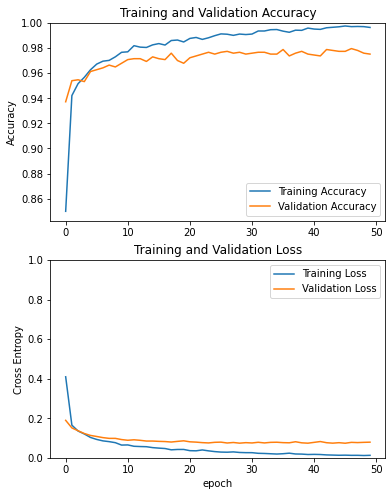

In [ ]:
plot_learning_curves(history2)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model2.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


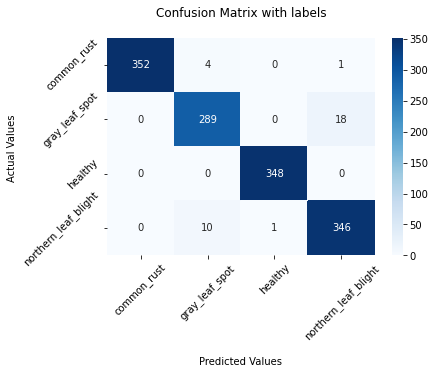

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  ['common_rust', 'gray_leaf_spot', 'healthy', 'northern_leaf_blight']

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       357
           1       0.95      0.94      0.95       307
           2       1.00      1.00      1.00       348
           3       0.95      0.97      0.96       357

    accuracy                           0.98      1369
   macro avg       0.97      0.97      0.97      1369
weighted avg       0.98      0.98      0.98      1369



### Save Model

In [ ]:
# save all model
modelname = "ResNet152V2"
save_all_model(modelname, model2, history2)

Export path:  saved_model/ResNet152V2
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  saved_model/BestMC_ResNet152V2
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  tflite_model/ResNet152V2
['leaf_resnet152v2.txt', 'leaf_resnet152v2.tflite']
'saved_model_history/OwnModel' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/OwnModel'
'saved_model_history/ResNet152V2' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/ResNet152V2'
'saved_model/OwnModel/variables/variables.data-00000-of-00001' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/OwnModel/variables/variables.data-00000-of-00001'
'saved_model/OwnModel/variables/variables.index' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/OwnModel/variables/variables.index'
'saved_model/OwnModel/saved_model.pb' -> 'drive/Shareddrives/T

## Model 3

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121

model3 = tf.keras.Sequential([
    DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_shape),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model3.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 4)                 

In [ ]:
model3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_DenseNet121.h5"),
)

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.8960
Epoch 1: val_accuracy improved from -inf to 0.90285, saving model to best_DenseNet121.h5
78/78 [==============================] - 62s 617ms/step - loss: 0.2660 - accuracy: 0.8960 - val_loss: 0.2470 - val_accuracy: 0.9028
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9866
Epoch 2: val_accuracy improved from 0.90285 to 0.95617, saving model to best_DenseNet121.h5
78/78 [==============================] - 44s 564ms/step - loss: 0.0421 - accuracy: 0.9866 - val_loss: 0.1298 - val_accuracy: 0.9562
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9945
Epoch 3: val_accuracy improved from 0.95617 to 0.97005, saving model to best_DenseNet121.h5
78/78 [==============================] - 44s 561ms/step - loss: 0.0210 - accuracy: 0.9945 - val_loss: 0.0818 - val_accuracy: 0.9701
Epoch 4/50
78/78 [==============================]

In [ ]:
score_train = model3.evaluate(train_generator)
score_valid = model3.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

14/14 [==============================] - 3s 173ms/step - loss: 0.0419 - accuracy: 0.9890
Accuracy (train):  1.0
Accuracy (test): 0.989043116569519
Loss (train):  1.56405058078235e-05
Loss (test): 0.041929587721824646


### Plot Learning Curves

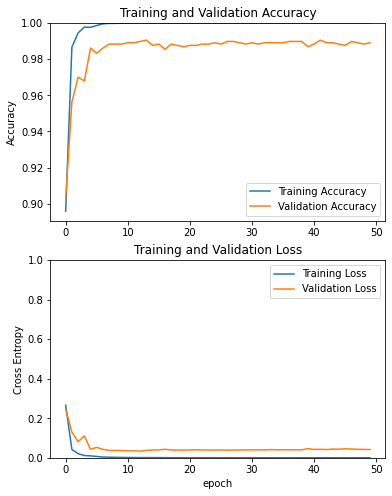

In [ ]:
plot_learning_curves(history3)

### Confusion Matrix & Classification Report

In [ ]:
y_test = validation_generator.classes
y_pred = model3.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


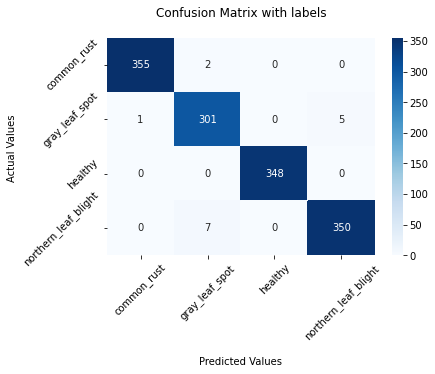

In [ ]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [ ]:
# show classification report
class_report(y_test, y_pred)

Labels:  ['common_rust', 'gray_leaf_spot', 'healthy', 'northern_leaf_blight']

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       357
           1       0.97      0.98      0.98       307
           2       1.00      1.00      1.00       348
           3       0.99      0.98      0.98       357

    accuracy                           0.99      1369
   macro avg       0.99      0.99      0.99      1369
weighted avg       0.99      0.99      0.99      1369



### Save Model

In [ ]:
# save all model
modelname = "DenseNet121"
save_all_model(modelname, model3, history3)

Export path:  saved_model/DenseNet121
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  saved_model/BestMC_DenseNet121
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  tflite_model/DenseNet121
['leaf_densenet121.tflite', 'leaf_densenet121.txt']
'saved_model_history/OwnModel' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/OwnModel'
'saved_model_history/ResNet152V2' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/ResNet152V2'
'saved_model_history/DenseNet121' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/DenseNet121'
'saved_model/OwnModel/variables/variables.data-00000-of-00001' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/OwnModel/variables/variables.data-00000-of-00001'
'saved_model/OwnModel/variables/variables.index' -> 'drive/Shareddrives/Tanamin Team/Machine

## Model 4

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=img_shape,
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = True

pre_trained_model.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

In [19]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [20]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(num_labels, activation='softmax')(x) 

model4 = tf.keras.Model(pre_trained_model.input, x)

model4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
              metrics=['accuracy'])

In [22]:
history4 = model4.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_InceptionV3.h5"),
)

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8669
Epoch 1: val_accuracy improved from -inf to 0.96713, saving model to best_InceptionV3.h5
78/78 [==============================] - 75s 705ms/step - loss: 0.3407 - accuracy: 0.8669 - val_loss: 0.0833 - val_accuracy: 0.9671
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9825
Epoch 2: val_accuracy improved from 0.96713 to 0.98685, saving model to best_InceptionV3.h5
78/78 [==============================] - 50s 643ms/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 0.0425 - val_accuracy: 0.9869
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9922
Epoch 3: val_accuracy did not improve from 0.98685
78/78 [==============================] - 50s 636ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.0381 - val_accuracy: 0.9869
Epoch 4/50
78/78 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9

In [23]:
score_train = model4.evaluate(train_generator)
score_valid = model4.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

14/14 [==============================] - 3s 194ms/step - loss: 0.0445 - accuracy: 0.9876
Accuracy (train):  1.0
Accuracy (test): 0.9875821471214294
Loss (train):  2.9901032121415483e-06
Loss (test): 0.04449444264173508


### Plot Learning Curves

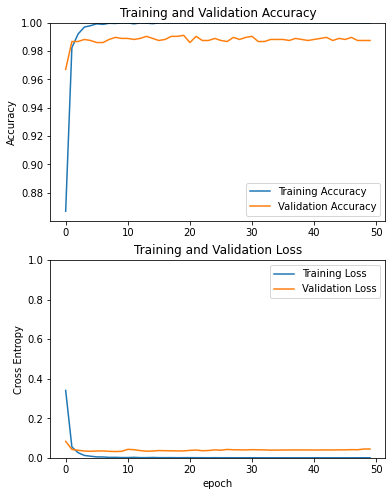

In [24]:
plot_learning_curves(history4)

### Confusion Matrix & Classification Report

In [25]:
y_test = validation_generator.classes
y_pred = model4.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


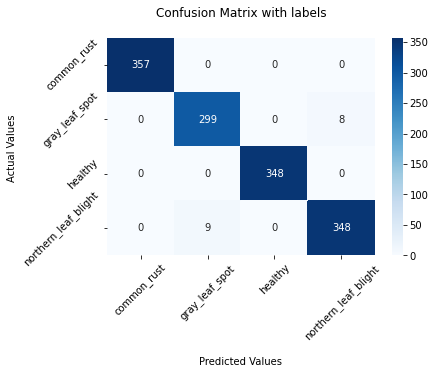

In [26]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [27]:
# show classification report
class_report(y_test, y_pred)

Labels:  ['common_rust', 'gray_leaf_spot', 'healthy', 'northern_leaf_blight']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       357
           1       0.97      0.97      0.97       307
           2       1.00      1.00      1.00       348
           3       0.98      0.97      0.98       357

    accuracy                           0.99      1369
   macro avg       0.99      0.99      0.99      1369
weighted avg       0.99      0.99      0.99      1369



### Save Model

In [28]:
# save model
modelname = "InceptionV3"
save_all_model(modelname, model4, history4)

Export path:  saved_model/InceptionV3
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  saved_model/BestMC_InceptionV3
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  tflite_model/InceptionV3
['leaf_inceptionv3.tflite', 'leaf_inceptionv3.txt']
'saved_model_history/InceptionV3' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/InceptionV3'
'saved_model/InceptionV3/variables/variables.data-00000-of-00001' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/InceptionV3/variables/variables.data-00000-of-00001'
'saved_model/InceptionV3/variables/variables.index' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/InceptionV3/variables/variables.index'
'saved_model/InceptionV3/saved_model.pb' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/InceptionV3/saved_model.pb'
'saved_model/InceptionV3/keras

## Model 5

In [30]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 

model5 = tf.keras.models.Sequential([
    MobileNetV2(weights="imagenet", include_top=False, input_shape=img_shape),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')  
])

model5.layers[0].trainable = False

model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [31]:
model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
history5 = model5.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
    callbacks = my_callbacks("best_MobileNetV2.h5"),
)

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.9155
Epoch 1: val_accuracy improved from -inf to 0.96275, saving model to best_MobileNetV2.h5
78/78 [==============================] - 24s 258ms/step - loss: 0.8063 - accuracy: 0.9155 - val_loss: 0.5706 - val_accuracy: 0.9627
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.9641
Epoch 2: val_accuracy did not improve from 0.96275
78/78 [==============================] - 18s 231ms/step - loss: 0.4759 - accuracy: 0.9641 - val_loss: 0.4212 - val_accuracy: 0.9613
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.9709
Epoch 3: val_accuracy did not improve from 0.96275
78/78 [==============================] - 18s 230ms/step - loss: 0.3444 - accuracy: 0.9709 - val_loss: 0.3424 - val_accuracy: 0.9576
Epoch 4/50
78/78 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.9743
Epoch 4: val_accuracy did not improve

In [33]:
score_train = model5.evaluate(train_generator)
score_valid = model5.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy (test):', score_valid[1])
print('Loss (train): ', score_train[0])
print('Loss (test):', score_valid[0])

14/14 [==============================] - 3s 188ms/step - loss: 0.1663 - accuracy: 0.9620
Accuracy (train):  0.9936985373497009
Accuracy (test): 0.9620160460472107
Loss (train):  0.0662410631775856
Loss (test): 0.16633562743663788


### Plot Learning Curves

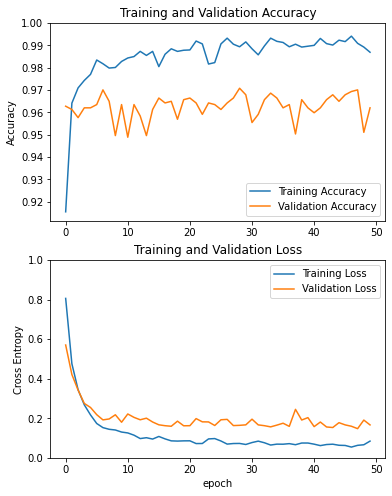

In [34]:
plot_learning_curves(history5)

### Confusion Matrix & Classification Report

In [35]:
y_test = validation_generator.classes
y_pred = model5.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


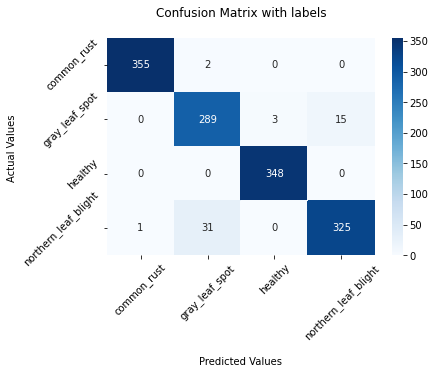

In [36]:
# show confusion matrix
conf_matrix(y_test, y_pred)

In [37]:
# show classification report
class_report(y_test, y_pred)

Labels:  ['common_rust', 'gray_leaf_spot', 'healthy', 'northern_leaf_blight']

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       357
           1       0.90      0.94      0.92       307
           2       0.99      1.00      1.00       348
           3       0.96      0.91      0.93       357

    accuracy                           0.96      1369
   macro avg       0.96      0.96      0.96      1369
weighted avg       0.96      0.96      0.96      1369



### Save Model

In [38]:
# save model
modelname = "MobileNetV2"
save_all_model(modelname, model5, history5)

Export path:  saved_model/MobileNetV2
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']


Export path:  saved_model/BestMC_MobileNetV2
['keras_metadata.pb', 'assets', 'saved_model.pb', 'variables']
Export path:  tflite_model/MobileNetV2
['leaf_mobilenetv2.txt', 'leaf_mobilenetv2.tflite']
'saved_model_history/InceptionV3' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/InceptionV3'
'saved_model_history/MobileNetV2' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history/MobileNetV2'
'saved_model/InceptionV3/variables/variables.data-00000-of-00001' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/InceptionV3/variables/variables.data-00000-of-00001'
'saved_model/InceptionV3/variables/variables.index' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/InceptionV3/variables/variables.index'
'saved_model/InceptionV3/saved_model.pb' -> 'drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model/InceptionV3/saved_mo

# Load All Model 

In [39]:
# delete folder
shutil.rmtree('saved_model', ignore_errors=True)
shutil.rmtree('saved_model_history', ignore_errors=True)
shutil.rmtree('tflite_model', ignore_errors=True)

In [ ]:
# copy folder
%cp -av "drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model_history" "/content"
%cp -av "drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/saved_model" "/content"
%cp -av "drive/Shareddrives/Tanamin Team/Machine Learning/models/corn_models/tflite_model" "/content"

# Choosing The Model

## Plot History All Model

In [42]:
list_modelnames = ["OwnModel", "ResNet152V2", "DenseNet121", "InceptionV3", "MobileNetV2"]
dict_histories = {}
saved_model_his = "saved_model_history"

# load model into new variable
for modelname in list_modelnames:
  with open(os.path.join(saved_model_his, modelname), 'rb') as file_pi:
    dict_histories[modelname] = pickle.load(file_pi)

dict_histories.keys()

dict_keys(['OwnModel', 'ResNet152V2', 'DenseNet121', 'InceptionV3', 'MobileNetV2'])

comparing accuracy history all model

In [43]:
dict_acc = {}
dict_val_acc = {}
dict_loss = {}
dict_val_loss = {}

for modelname in list_modelnames:
  dict_acc[modelname] = dict_histories[modelname]['accuracy']
  dict_val_acc[modelname] = dict_histories[modelname]['val_accuracy']
  dict_loss[modelname] = dict_histories[modelname]['loss']
  dict_val_loss[modelname] = dict_histories[modelname]['val_loss']

label_plot = ['Own Model','ResNet152V2','DenseNet121','InceptionV3','MobileNetV2']
marker_plot = ['o','x','v','^','d']

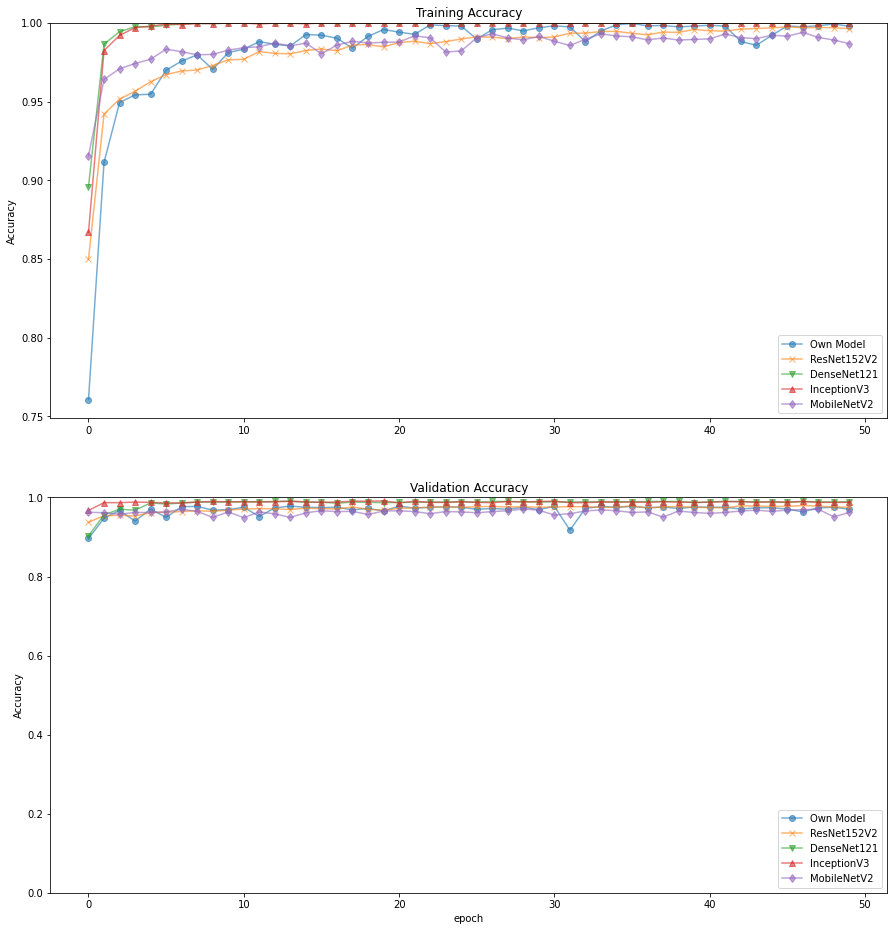

In [44]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)
for i in range(len(list_modelnames)):
  plt.plot(dict_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
for i in range(len(list_modelnames)):
  plt.plot(dict_val_acc[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('acc_all_model.png')

plt.show()

comparing loss history all model

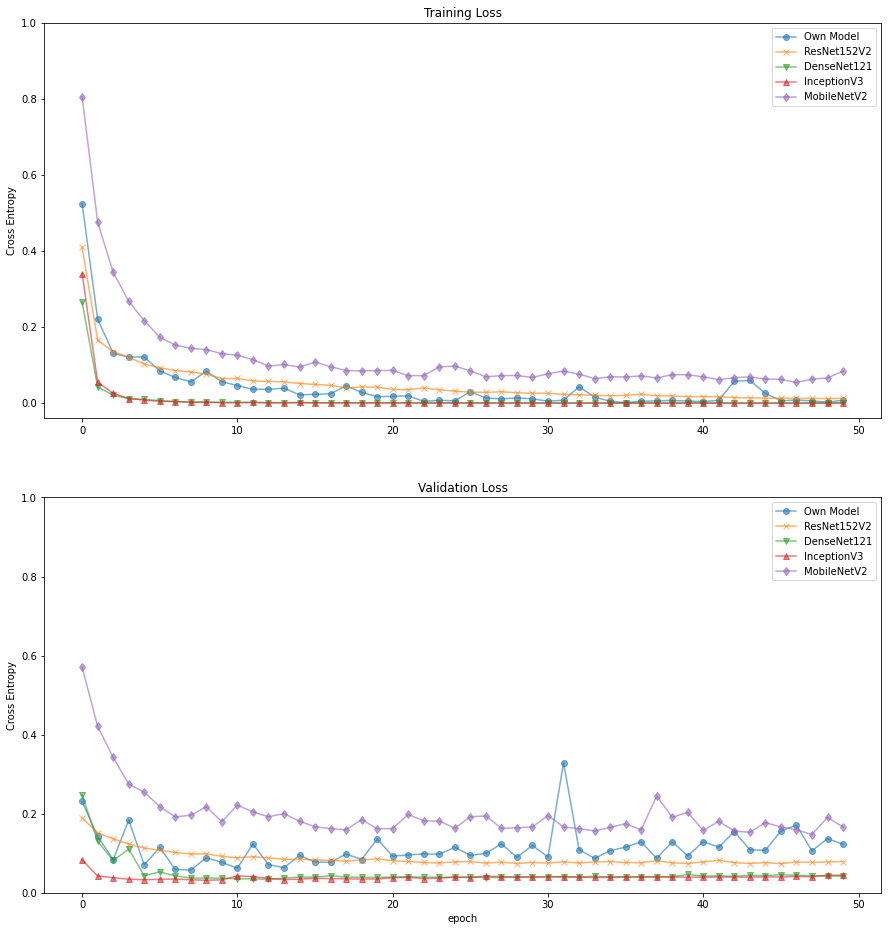

In [45]:
plt.figure(figsize=(15, 16))
plt.subplot(2, 1, 1)

for i in range(len(list_modelnames)):
  plt.plot(dict_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)

plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Loss')

plt.subplot(2, 1, 2)

for i in range(len(list_modelnames)):
  plt.plot(dict_val_loss[list_modelnames[i]], label=label_plot[i], marker=marker_plot[i], markersize=6, alpha=0.6)
  
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Validation Loss')
plt.xlabel('epoch')

plt.savefig('loss_all_model.png')

plt.show()

## Plot Performance All Best Model

In [46]:
list_modelnames = ["OwnModel", "ResNet152V2", "DenseNet121", "InceptionV3", "MobileNetV2"]
dict_models = {}

# load model into new variable
for modelname in list_modelnames:
  dict_models[modelname] = tf.keras.models.load_model('saved_model/BestMC_{}'.format(modelname))

dict_models.keys()

dict_keys(['OwnModel', 'ResNet152V2', 'DenseNet121', 'InceptionV3', 'MobileNetV2'])

In [47]:
# evaluate all model
dict_score_train = {}
dict_score_valid = {}

for modelname in list_modelnames:
  dict_score_train[modelname] = dict_models[modelname].evaluate(train_generator)
  dict_score_valid[modelname] = dict_models[modelname].evaluate(validation_generator)

14/14 [==============================] - 3s 187ms/step - loss: 0.1643 - accuracy: 0.9708


In [48]:
# prepare data before plot
df1 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[1] for eval in dict_score_train.values()],
    'Valid': [eval[1] for eval in dict_score_valid.values()],
})

df2 = pd.DataFrame({
    'Model': list_modelnames,
    'Train': [eval[0] for eval in dict_score_train.values()],
    'Valid': [eval[0] for eval in dict_score_valid.values()],
})

tidy1 = df1.melt(id_vars='Model').rename(columns=str.title)

tidy2 = df2.melt(id_vars='Model').rename(columns=str.title)

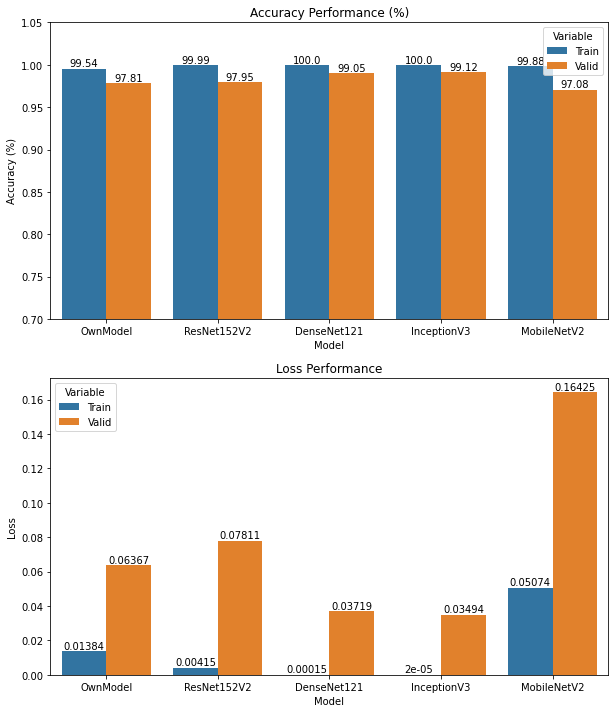

In [49]:
# plot comparison all models evaluate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# first plot
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy1, ax=ax1)
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim([0.7 ,1.05])
ax1.set_title('Accuracy Performance (%)')

for p, data in zip(ax1.patches, tidy1['Value']):
    ax1.annotate(round(data*100, 2), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

# second plot
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy2, ax=ax2)
ax2.set_ylabel('Loss')
ax2.set_title('Loss Performance')

for p, data in zip(ax2.patches, tidy2['Value']):
    ax2.annotate(round(data, 5), xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom')

plt.savefig('evaluate_all_model.png')
plt.show()

## Conclusion

**DenseNet121 Model** has high accuracy and lower loss also the model is not too complex, it will be used for Corn Leaf Disease Prediction feature

# Predict Model with User Image Input

In [ ]:
best_model = tf.keras.models.load_model('saved_model/BestMC_DenseNet121')

In [ ]:
# get user image input
labels = ['Early Blight', 'Late Blight', 'Healthy']

uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  images = np.vstack([x])
  images /= 255

  classes = best_model.predict(images, batch_size=32)
  predicted_class_indices=np.argmax(classes)


print("\nPredict:")
if predicted_class_indices == 0:
  print('Early Blight')
elif predicted_class_indices == 1:
  print('Late Blight')
elif predicted_class_indices == 2:
  print('Healthy')

print("\nProbablity:")
for idx, val in enumerate(labels):
  print("{} : {:.2f}%".format(val, classes[0][idx] * 100))